# Vignette 4: Sensitive response to drug perturbation using phosphoproteomics

The aim of this vignette is to explore a new way of evaluating the networks. In this setting, we assume that the networks that better contextualise the perturbation will have a higher average pEC50 in the nodes included in the solution network, compared to the ones not included. On the contrary, the networks which are not able to contextualise the perturbation will not show differences in the EC50 values of the nodes included or excluded. For more information about this evaluation strategy, please check the dedicated [section](../benchmarks.html#phosphorylation-sensitivity-to-drug-perturbation).

In [1]:
import networkcommons as nc
import pandas as pd
import decoupler as dc

## 1. Data processing

To showcase this strategy, we will use data from the [DecryptM](../datasets.html#decryptm) resource, a compendium of 14 different experiments comprising 4 different proteomics profiles and 31 different drugs. This dataset contains 10 different concentration points, which were used to fit logistic curves to obtain sensitivity values (pEC50, which is -log(EC50), higher sensitivity results in a higher pEC50 or a lower EC50). EC50 is the concentration at which the response is halfway between the baseline activity and the maximum activity. 

> Jana Zecha et al., Decrypting drug actions and protein modifications by dose- and time-resolved proteomics. *Science 380,93-101(2023)*. https://doi.org/10.1126/science.ade3925

To see in a nutshell the available experiments from the resource, we can use `nc.data.omics.decryptm_datasets`


<div class="alert alert-info">

**Note**
    
Here, we assume that the averaging of phosphosite-level information is a good approximation for changes at the protein level. However, this is not necessarily true. For example, in case of proteins with multiple phosphorylation sites, some of them can result in the protein becoming more active, while others can make it become less active. In addition, some proteins become active/inactive only when a minimum of n phosphorylation sites have been phosphorylated. All these examples are ingnored in this setting, and thus should be taken into account when interpreting the results.

</div> 

For the sake of simplicity, we will focus on one drug targeting EGFR. We get the 3 EGFR inhibitors:

In [2]:
decryptm_curves = nc.data.omics.decryptm_table('3_EGFR_Inhibitors', 'Phosphoproteome', 'curves.txt')

We first filter those fittings with a high R2. We define here an arbitrary threshold of 0.9

In [3]:
filtered_df = decryptm_curves[decryptm_curves['R2']>0.9]

Now, we can extract the information from each sample by splitting the Experiment column:

In [ ]:
filtered_df[['PTM', 'Cell_line', 'Drug', 'Time', 'Rep']] = filtered_df['Experiment'].str.split('_', expand=True)

We can see which drug has the most fitted curves, which will be the one we will choose for this analysis. 

In [5]:
filtered_df['Drug'].value_counts()

Drug
Afatinib     4054
Gefitinib    1515
Dasatinib    1368
Name: count, dtype: int64

With 4054 fitted curves, we can continue the analysis focusing in Afatinib.

In [6]:
filtered_df = filtered_df[filtered_df['Drug'] == 'Afatinib']

We binarise the Regulation column:

In [7]:
filtered_df['Regulation'] = filtered_df['Regulation'].map({'up': 1, 'down': -1}).fillna(0)

Now, since our prior knowledge network is detailed to the protein level, we need to summarise our phosphosite-specific information. For this, we can just calculate the average across phosphosites and replicates, per protein.

In [8]:
numeric_cols = filtered_df.select_dtypes(include=[float, int]).columns
grouped_df = filtered_df.groupby(['PTM', 'Cell_line', 'Drug', 'Time', 'Gene names'])[numeric_cols].mean()
grouped_df.reset_index(inplace=True)

We discard those proteins which showed no response:

In [9]:
grouped_df = grouped_df[grouped_df['Regulation'] != 0]

Now, we split our dataset in two. On one side, we will use the transcription factors (TFs) for the measurement layer (upregulated or downregulated). The rest of measurements which are not TFs will be used for the evaluation.

In [10]:
collectri = dc.get_collectri()
collectri_tfs = set(collectri.source)

In [11]:
measurements = grouped_df[grouped_df['Gene names'].isin(collectri_tfs)]
measurements.head()

,PTM,Cell_line,Drug,Time,Gene names,N duplicates,Length,Missed cleavages,Phospho (STY),Max Score,...,R2,Curve RMSE,Log EC50 error,Curve slope error,Curve top error,Curve bottom error,EC50,pEC50,Curve effect size,Regulation
37,ddPTM,A431,Afatinib,30min,AKNA,1.00,8.000000,0.000000,1.000000,97.565000,...,0.930210,0.079855,0.078054,0.326630,0.022948,0.021961,1.081113e-08,7.966129,-0.633375,-1.000000
77,ddPTM,A431,Afatinib,30min,ARHGAP35,1.25,15.416667,0.583333,1.166667,219.326917,...,0.951323,0.063784,0.113077,1.232567,0.022569,0.030057,1.907749e-07,7.873396,-0.673425,-0.833333
106,ddPTM,A431,Afatinib,30min,ATF7,1.20,15.400000,0.400000,1.600000,231.716000,...,0.939197,0.046872,2.402108,0.517590,0.020224,2.005207,2.000098e-03,6.252465,0.540893,-0.200000
113,ddPTM,A431,Afatinib,30min,ATRX,1.00,12.125000,1.000000,1.250000,205.422625,...,0.925583,0.059691,0.129673,0.607281,0.020850,0.023965,1.983393e-08,8.059884,-0.060007,-0.125000
128,ddPTM,A431,Afatinib,30min,BCL3,1.10,16.000000,1.000000,1.400000,131.791200,...,0.945352,0.093729,0.093656,0.186224,0.040301,0.036615,7.787948e-09,8.132247,-0.125451,-0.400000


In [12]:
ec50_values = grouped_df[~grouped_df['Gene names'].isin(collectri_tfs)]
ec50_dict = dict(zip(grouped_df['Gene names'], grouped_df['pEC50']))
list(ec50_dict.items())[:5]

[('ABLIM3', 8.038036722142818),
 ('ACACA', 7.919001347352594),
 ('ACIN1', 8.51245270397656),
 ('ADAM17', 8.088225031254964),
 ('ADAR', 8.209162778966169)]

## 2. Network inference

Afatinib is an EGFR inhibitor, therefore:

In [13]:
source_dict = {'EGFR': -1}

We get the top 30 most sensitive TFs.

In [20]:
measurements = measurements.sort_values('pEC50', ascending=False)
measurements = measurements.head(30)

In [15]:
target_dict = dict(zip(measurements['Gene names'], measurements['Regulation']))

Now we compute the contextualised networks using four different topological methods: shortest paths and all paths, with and without sign consistency.

In [16]:
network_df = nc.data.network.get_omnipath()
network = nc.utils.network_from_df(network_df)

Now, we will perform network inference with some topology methods and CORNETO-Carnival.

<div class="alert alert-warning">

**Warning**
    
The following code block uses CORNETO, a package specialised in Integer Linear programming for network inference. Some CORNETO methods (such as Carnival) depend on GUROBI, a third-party solver that holds a commercial license. Therefore, in order to run this part of the code, you will have to install a license in your system. Please check their home page for more information. 

</div>

In [ ]:
network_dict = {}

network_dict['corneto_network'] = nc.methods.run_corneto_carnival(network, source_dict, target_dict, betaWeight=0.01, solver='GUROBI')
network_dict['shortest_paths'], shortest_paths = nc.methods.run_shortest_paths(network, source_dict, target_dict)
network_dict['shortest_paths_sc'], shortest_paths_sc = nc.methods.run_sign_consistency(network, shortest_paths, source_dict, target_dict)
network_dict['all_paths'], all_paths = nc.methods.run_all_paths(network, source_dict, target_dict, depth_cutoff=5)
network_dict['all_paths_sc'], all_paths_sc = nc.methods.run_sign_consistency(network, all_paths, source_dict, target_dict)

## 3. Evaluation using sensitivity to perturbation

Finally, we can assess whether these networks contain a differential share of highly sensitive nodes, which will be our evaluation metric. For more information, please check the [Evaluation strategies details page](../benchmarks.html#phosphorylation-sensitivity-to-drug-perturbation).

In [18]:
ec50_eval_results = nc.eval.get_metric_from_networks(network_dict, nc.eval.get_ec50_evaluation, ec50_dict=ec50_dict)

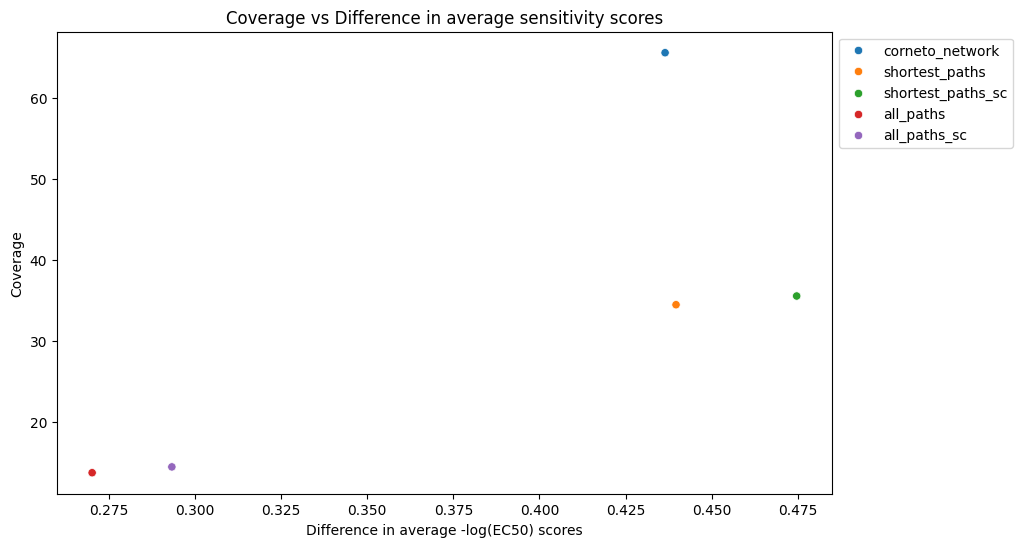

In [19]:
p = nc.visual.plot_scatter(
    ec50_eval_results,
    x_col='diff_EC50',  
    y_col='coverage',
    size_col=None,
    hue_col='method',
    numeric_cols=None,
    style_col=None,
    xlabel='Difference in average -log(EC50) scores',  
    ylabel='Coverage',  
    title='Coverage vs Difference in average sensitivity scores',  
    figsize=(10, 6),  
)  

Both corneto and shortest paths + sign consistency had the highest difference between EC50 values of nodes included and excluded of the solution networks. In addition, the corneto network has almost double coverage than the rest of the networks. Therefore, we would consider the corneto network a better performer, taking both dimensions into account.

That was it! Here, we used phosphoproteomics to infer mechanistic explanations of sensitivity changes in transcription factors, and then we used the same sensitivity information to evaluate the different methodologies. In our next vignette, we will explore the usage of multiomics in another evaluation setting. Bye!